# Predict volume from LiDAR features

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

/home/mayrajeo/miniconda3/envs/enveco/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular.preprocessing import *
from enveco.interpretation import *
from enveco.model.ensemble import *
from enveco.metrics import *

Run the example workflow for predicting the volume of the field plot from LiDAR-derived features.

# Read and preprocess data

In [3]:
#data_path = Path('../../../andras/ml/AV_leafon/')
data_path = Path('../../enveco_data/enveco/')
preprocessor = EnvecoPreprocessor(data_path/'AV.leaf.on.train.csv', 
                                  data_path/'AV.leaf.on.val.csv',
                                  data_path/'AV.leaf.on.test.csv')

Preprocess dataframes and extract features from them. 
Also, specify whether to `normalize` data (default: True) or to log-transform target column (default: False)

In [ ]:
trainval_tb, test_tb = preprocessor.preprocess(target_col=['v_lp'], 
                                               path=data_path,
                                               lidar_pref='AV_las',
                                               image_pref='AV_tif',
                                               mask_plot=False,
                                               min_h=1.3,
                                               normalize=True,
                                               log_y=False,
                                               
                                               save_path='../../enveco_data'
                                              )

If all features are already preprocessed, it's possible to use saved features and save a bit of time.

In [5]:
trainval_tb, test_tb = preprocessor.load_las_image(path='../../enveco_data', target_col=['v', 'v_ma', 'v_ku', 'v_lp'], log_y=False)

Previous method returns two `TabularPandas` objects. Put them to dataloaders.

In [6]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock)

Check the distribution of the target variable `v`, in order to get limits for `sigmoid_range`.

In [7]:
trainval_tb.train.y.describe()

count    1044.000000
mean      145.712250
std        86.097336
min         2.700000
25%        80.927498
50%       132.125000
75%       191.305000
max       867.349976
Name: v, dtype: float64

In [8]:
trainval_tb.valid.y.describe()

count    225.000000
mean     150.768631
std       95.610825
min        2.310000
25%       87.419998
50%      133.600006
75%      191.639999
max      539.479980
Name: v, dtype: float64

In [9]:
test_tb.train.y.describe()

count    225.000000
mean     152.013641
std       97.223846
min        7.000000
25%       87.820000
50%      134.979996
75%      192.529999
max      550.169983
Name: v, dtype: float64

# ANN

Create `Learner` object. Specify y_range to better control the training, set 1000 m³ as the maximum value for the total volume.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias. Target variable is log-transformed, so all metrics are log-equivalents (so MSLE, RMSLE...).

In [26]:
learn = tabular_learner(dls, 
                        metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  
                        y_range=(Tensor([0 for _ in range(dls.c)]), Tensor(trainval_tb.train.ys.max().values*1.1))
                       )
learn.summary()

TabularModel (Input shape: 64 x torch.Size([64, 174]))
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 174            
BatchNorm1d                               348        True      
BatchNorm1d                               348        True      
____________________________________________________________________________
                     64 x 200            
Linear                                    34800      True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     64 x 100            
Linear                                    20000      True      
ReLU                                                           
____________________________________________________________________________
                     64 x 4              
Linear                            

Find learning rate to use.

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.004365158267319202)

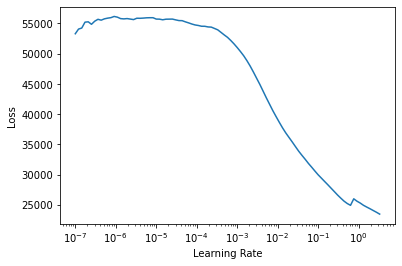

In [12]:
learn.lr_find()

1e-2 seems to be a good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,38427.500000,31249.013672,176.773911,234.496948,158.935822,210.834091,164.485992,-2.956089,00:00
1,24726.910156,7836.040039,88.521408,117.426834,50.865467,67.474876,71.314453,0.007966,00:00
2,15645.874023,3729.646973,61.070835,81.012657,-7.669888,-10.174383,40.332264,0.527831,00:00
3,10807.282227,2812.283691,53.030968,70.347488,-12.922631,-17.142336,33.135860,0.643968,00:00
4,7808.840820,2481.576660,49.815426,66.081963,0.256472,0.340219,30.218939,0.685835,00:00
5,5784.954590,1618.541504,40.231102,53.368008,0.023105,0.030649,24.351984,0.795094,00:00
6,4419.649902,1604.180298,40.052219,53.130711,1.182714,1.568913,23.506037,0.796913,00:00
7,3540.375000,1813.436890,42.584469,56.489830,2.781246,3.689424,26.599092,0.770421,00:00
8,2922.375732,1623.782471,40.296185,53.454338,1.270371,1.685193,25.218550,0.794431,00:00
9,2503.969727,1884.743042,43.413628,57.589741,0.461614,0.612348,25.770172,0.761394,00:00


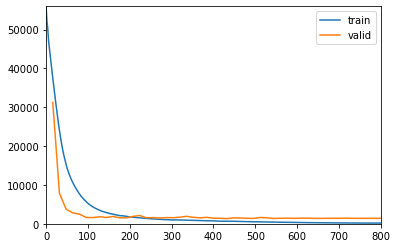

In [13]:
learn.fit_one_cycle(50, lr_max=1e-2, cbs=ShowGraphCallback())

See validation results

In [14]:
learn.validate()

(#7) [1413.9820556640625,37.60295486450195,49.88167190551758,0.8284361958503723,1.0989505052566528,21.741046905517578,0.8209914711384821]

In [15]:
preds, true = learn.get_preds()

`RegressionInterpretation` can be used to plot results.

In [16]:
reg_interp = RegressionInterpretation.from_learner(learn)

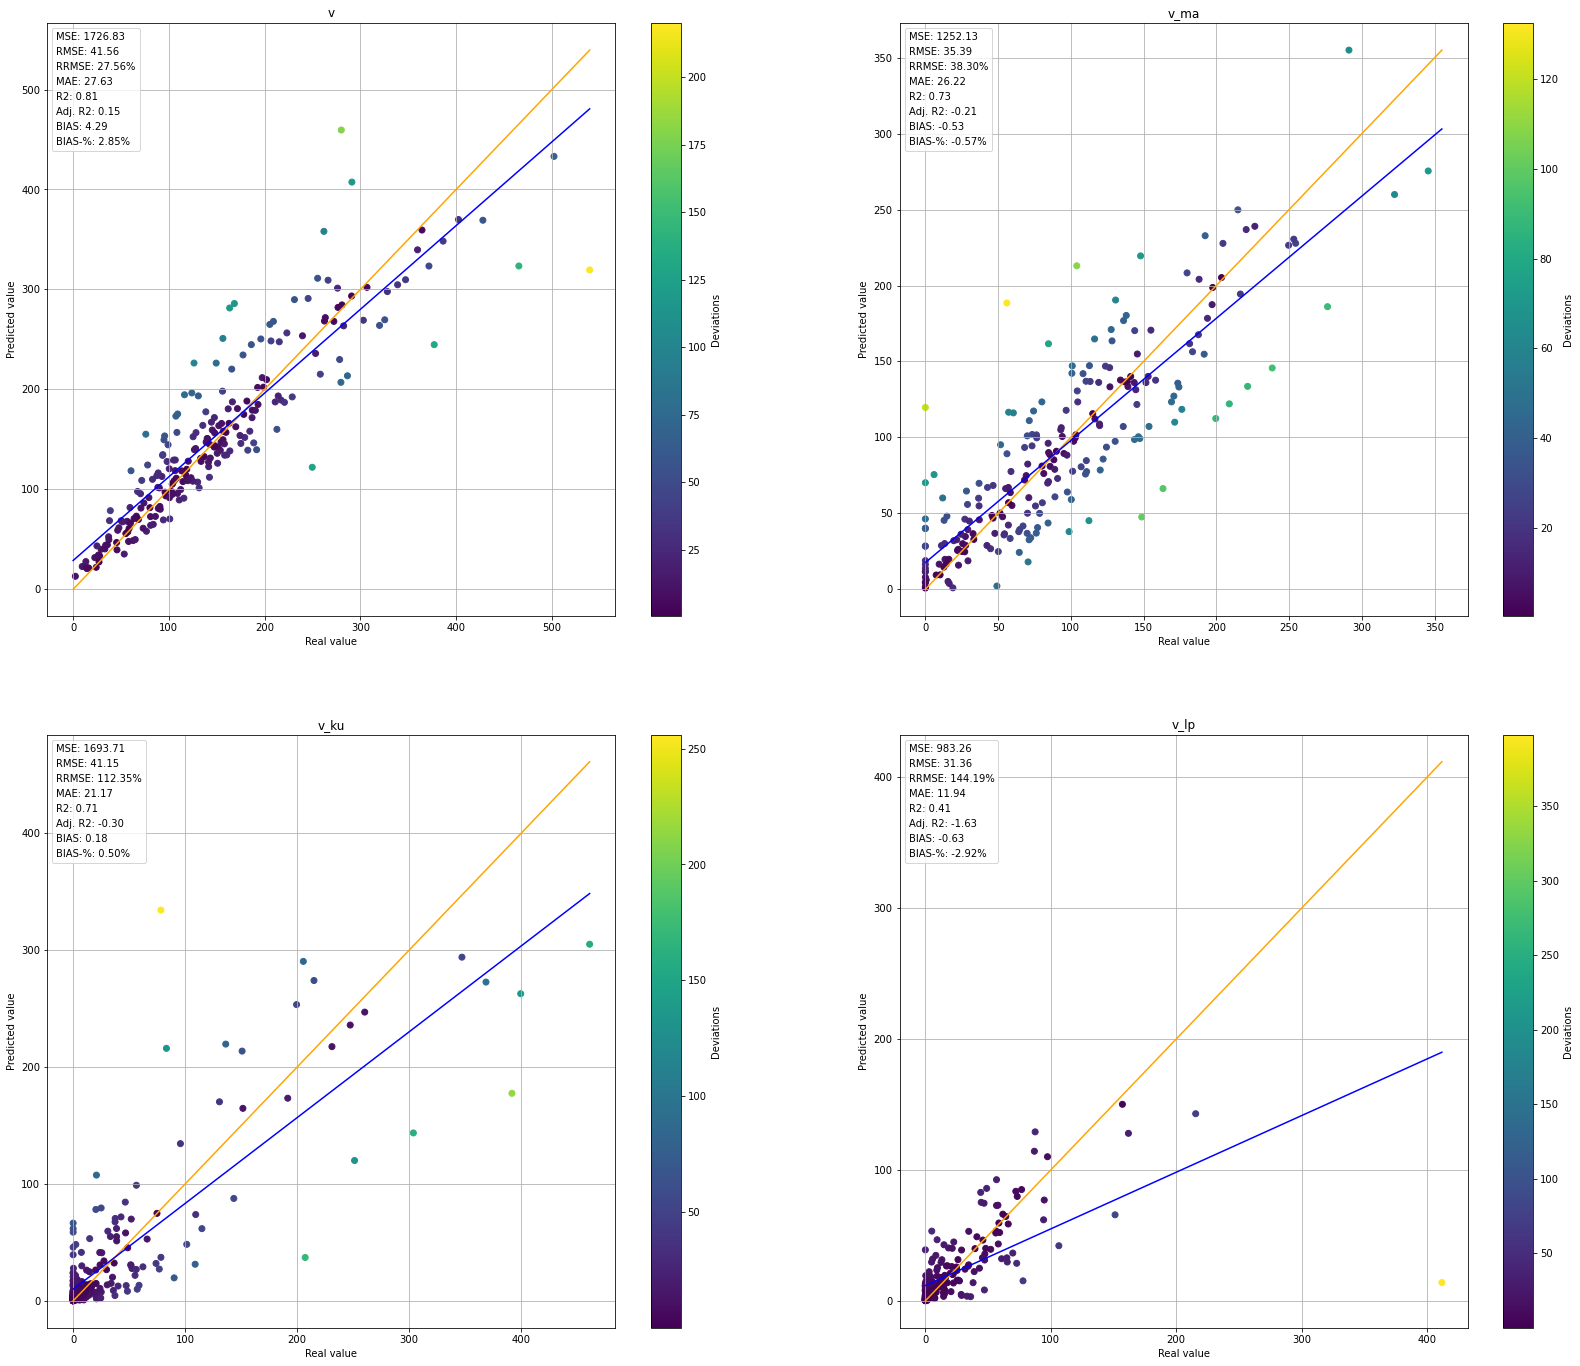

In [17]:
reg_interp.plot_results(log_y=False)
plt.show()

Evaluate test set.

In [18]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [19]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls.train, ds_idx=0)

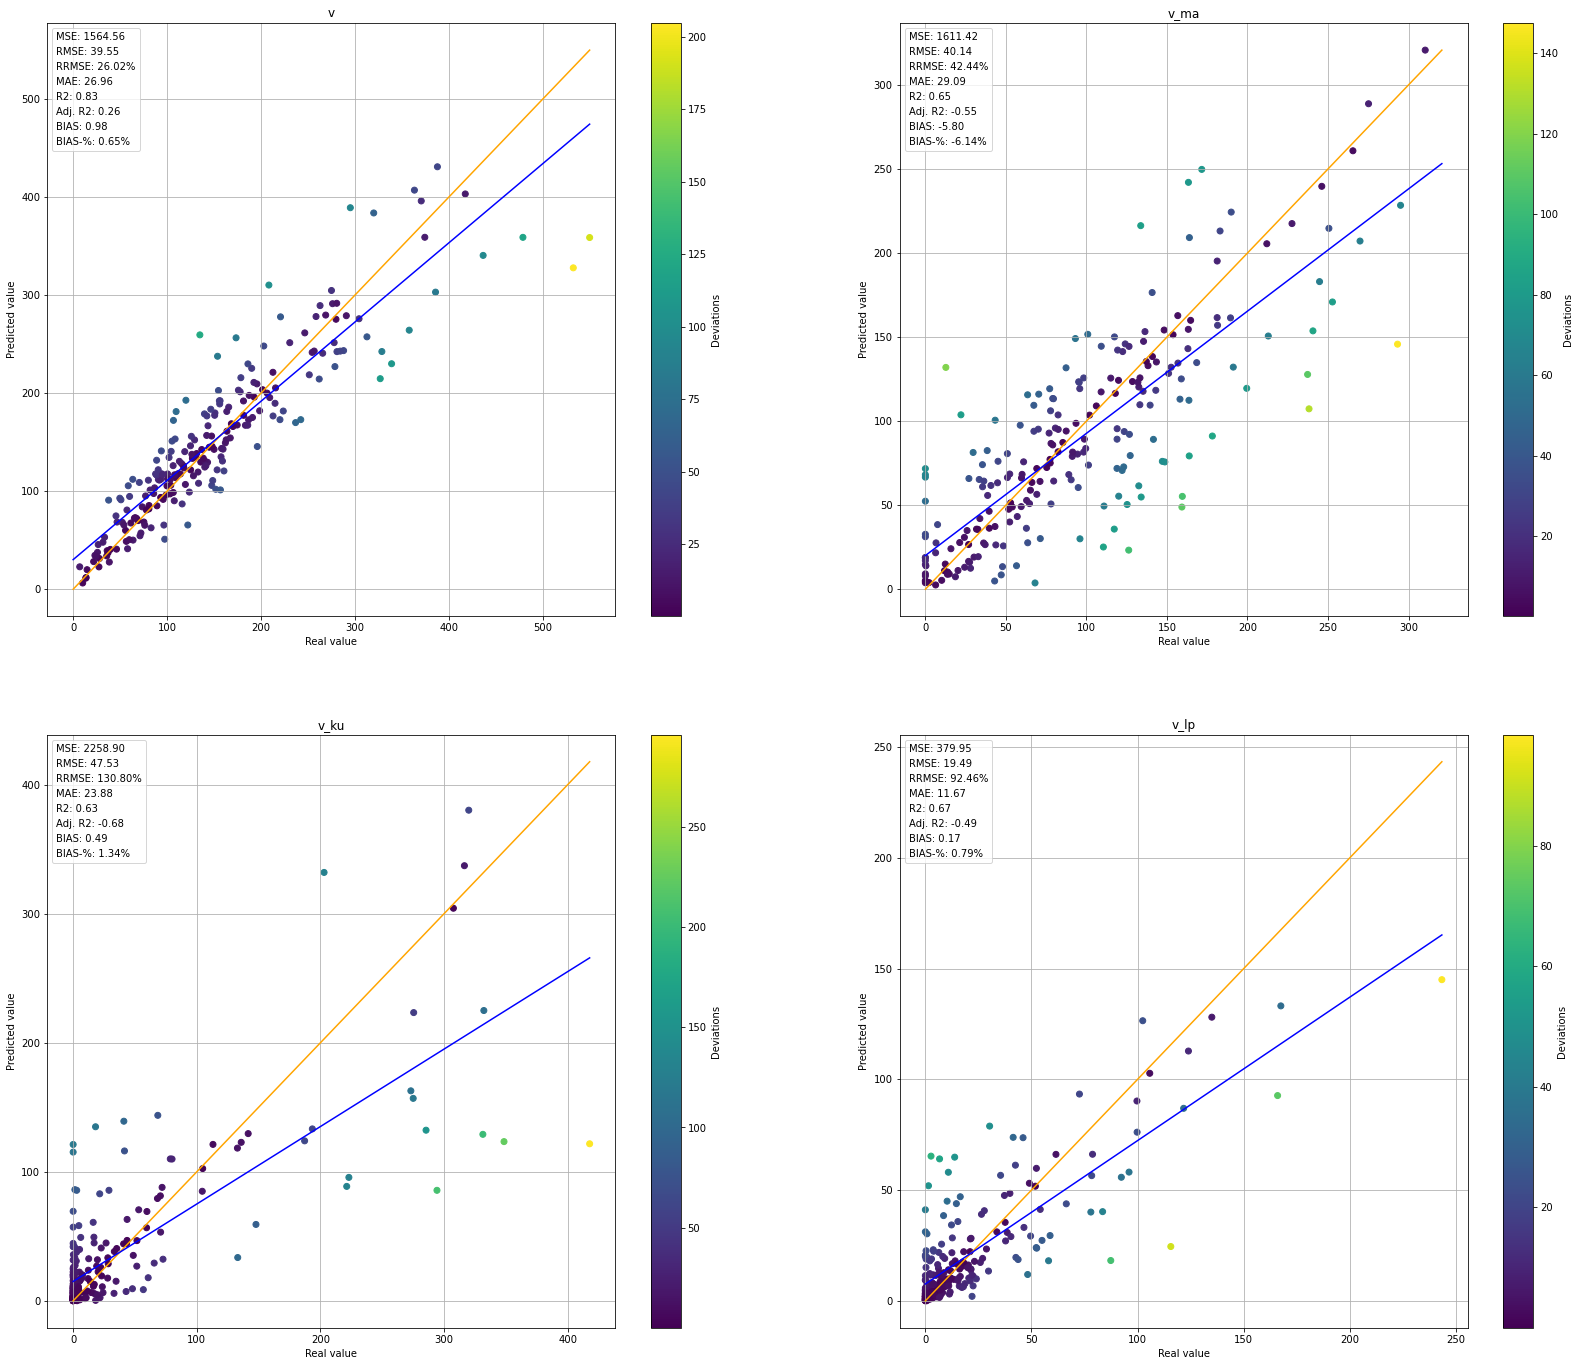

In [20]:
test_interp.plot_results(log_y=False)
plt.show()

In [53]:
test_preds = learn.get_preds(dl=test_dls.train,)

In [54]:
sp_tot_v = test_preds[1][:,1:].sum(axis=-1)

In [55]:
np.abs((sp_tot_v - test_preds[1][:,0])).max()

tensor(0.0100)

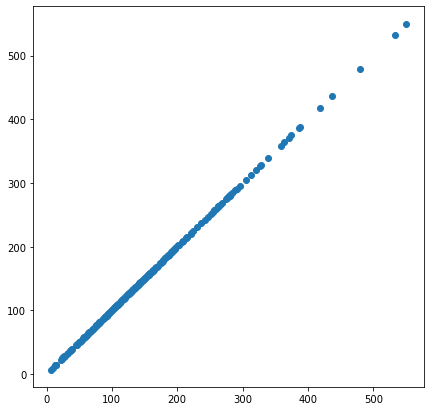

In [56]:
fig = plt.figure(figsize=(7,7))
plt.scatter(test_preds[1][:,0].numpy(), sp_tot_v.numpy())

# Ensemble of ANNs

Fit several models at once.

In [27]:
ensemble = Ensemble(dls, learn_func=tabular_learner, ens_dir='ensembles',
                    y_range=(Tensor([0 for _ in range(dls.c)]), Tensor(trainval_tb.train.ys.max().values*1.1)),
                    metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], 
                    n_models=10)

In [28]:
ensemble.fit_one_cycle(20, 1e-2)

In [29]:
res = ensemble.validate()

AssertionError: ==:
225
900

See ensemble validation results.

In [30]:
res

NameError: name 'res' is not defined

In [31]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

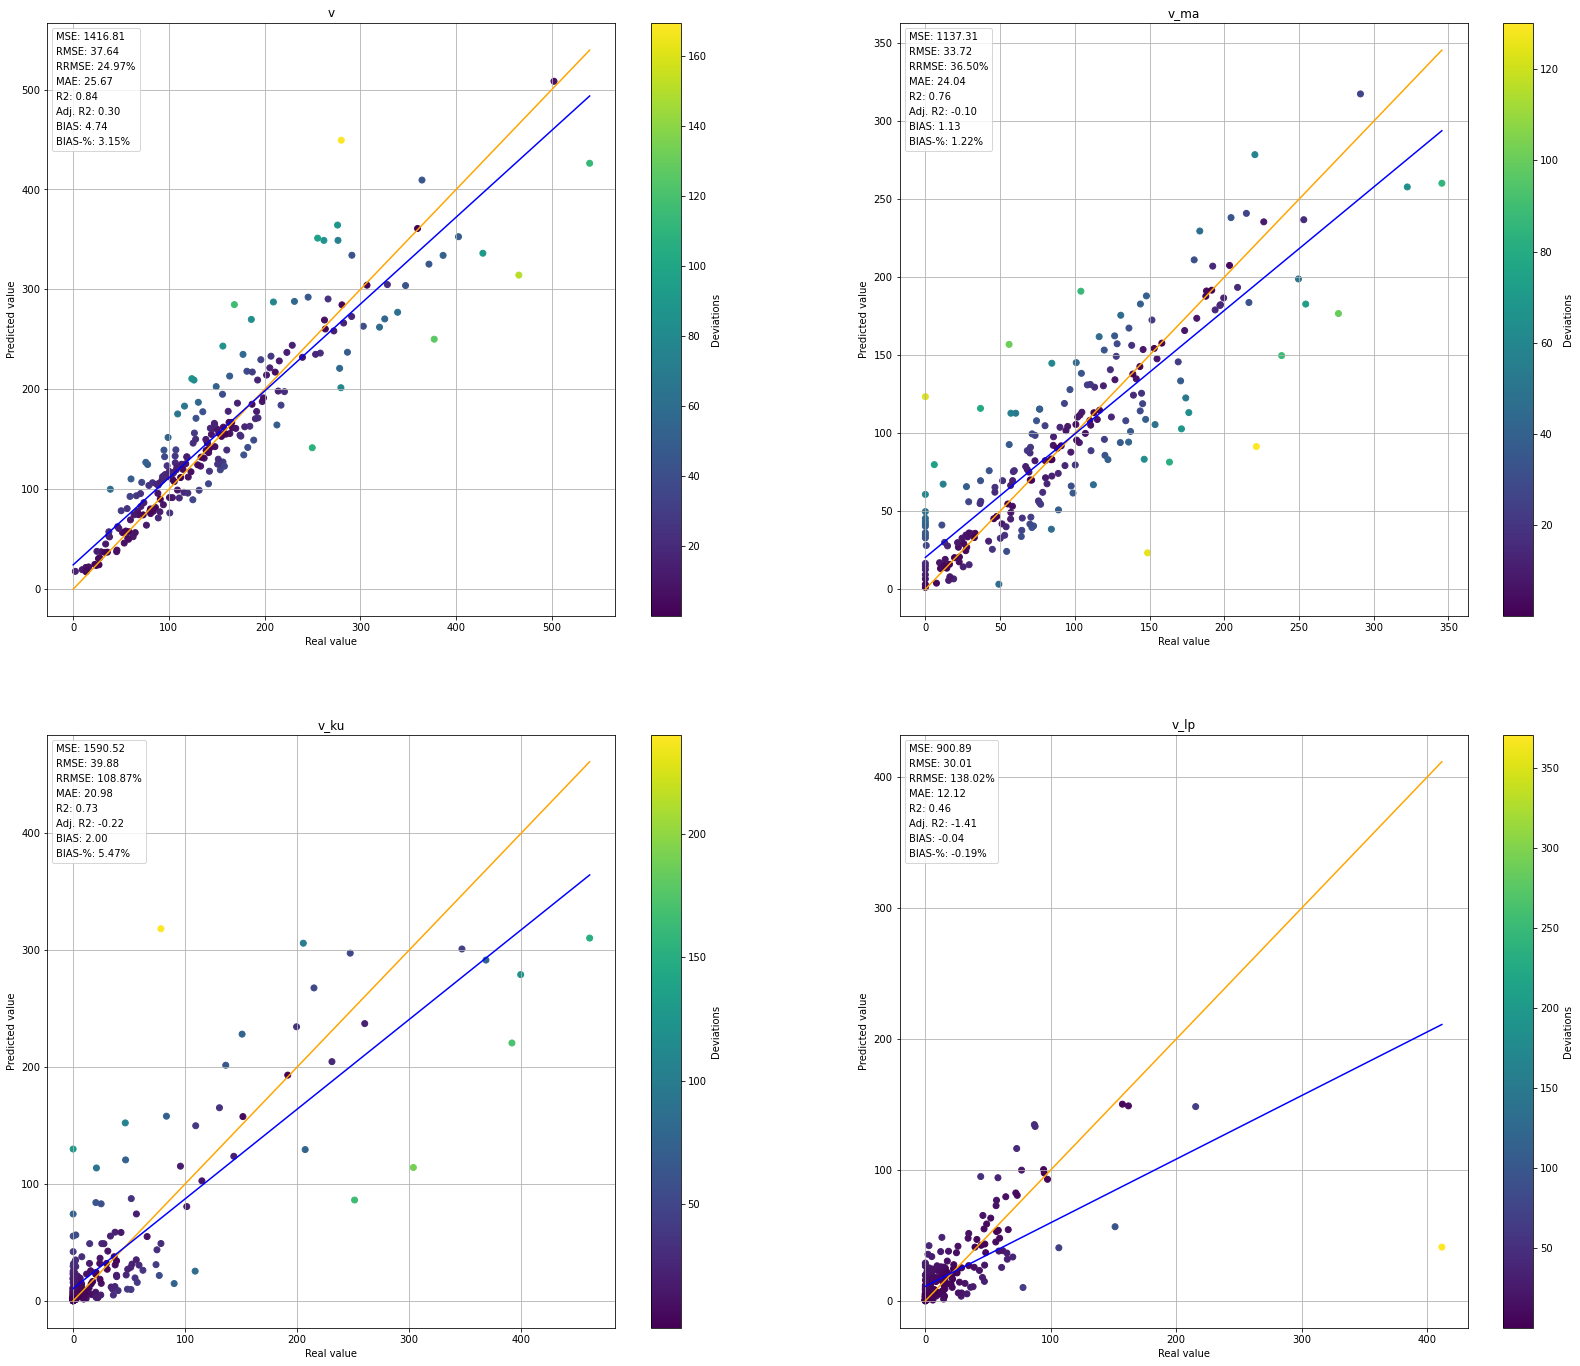

In [32]:
ens_int.plot_results(log_y=False)
plt.show()

Run test set predictions.

In [36]:
ens_preds = ensemble.get_ensemble_preds(dl=test_dls[0])

In [39]:
ens_preds[1].shape

torch.Size([225, 4])

In [43]:
ens_preds[1][:,1:].sum(axis=-1)

tensor([167.4363, 384.8292, 207.6193, 365.0411, 373.5990,  87.6758,  26.2960,
        204.0982, 245.5544, 267.7249, 288.8014, 153.0224,  48.1679, 259.2341,
        248.4898,  27.2252, 262.7358,  63.9633,  94.3494, 158.6845, 159.0415,
        115.7195, 259.7419, 373.7574,  25.4547, 177.8111, 392.5849,  71.2252,
        152.4535, 131.1500, 100.8123,  32.1560,  73.7151,  69.8664, 151.7585,
        249.3109, 119.5770, 122.2788, 128.0118, 192.8621, 210.8795,  33.6333,
        295.8719, 221.7013, 393.6740, 166.4026, 258.2411, 193.2883, 150.8703,
         75.2475,  95.9682, 189.9217, 109.2475, 201.7974, 130.8342, 110.8481,
        118.9935, 142.9372,  95.1811,  80.3633,   8.1735, 148.7955, 298.9255,
        363.3705, 122.1451, 119.5915, 136.1331, 232.0042,  82.3484,  82.4283,
        139.9717, 109.9117,  97.0990, 190.3569, 161.8318, 135.7061,  16.6845,
        110.2683,  80.3747, 146.2016, 191.9415, 111.1286,  94.7342, 115.2961,
        217.6264,  42.6137, 171.8116, 107.1770, 242.7746,  22.86

In [52]:
ens_preds[1][:,1:]

tensor([[9.3154e+00, 8.6743e+01, 7.1378e+01],
        [8.1764e+00, 3.3245e+02, 4.4203e+01],
        [1.3828e+02, 3.0045e+01, 3.9298e+01],
        [1.9508e+02, 1.6028e+02, 9.6896e+00],
        [2.2033e+02, 1.2430e+02, 2.8974e+01],
        [6.2736e+01, 1.2356e+01, 1.2584e+01],
        [1.1523e+01, 5.3646e+00, 9.4082e+00],
        [1.3169e+02, 4.5986e+01, 2.6417e+01],
        [6.2031e+00, 2.0766e+02, 3.1687e+01],
        [2.6990e+01, 1.2977e+02, 1.1097e+02],
        [2.7636e+02, 4.9955e+00, 7.4495e+00],
        [1.6336e+01, 1.1612e+01, 1.2507e+02],
        [4.1104e+01, 1.3929e+00, 5.6712e+00],
        [5.9626e+01, 5.1765e+01, 1.4784e+02],
        [7.5403e+00, 1.3534e+02, 1.0561e+02],
        [4.1013e+00, 1.0585e+01, 1.2538e+01],
        [1.1695e+02, 1.0061e+02, 4.5176e+01],
        [6.3130e+01, 3.4734e-01, 4.8635e-01],
        [8.2768e+01, 4.6996e+00, 6.8821e+00],
        [6.4951e+01, 5.9864e+01, 3.3869e+01],
        [1.1804e+02, 2.4879e+01, 1.6122e+01],
        [5.7993e+01, 3.7470e+01, 2

In [61]:
ens_preds[1][0,1:], ens_preds[1][0,0]

(tensor([ 9.3154, 86.7428, 71.3782]), tensor(170.3323))

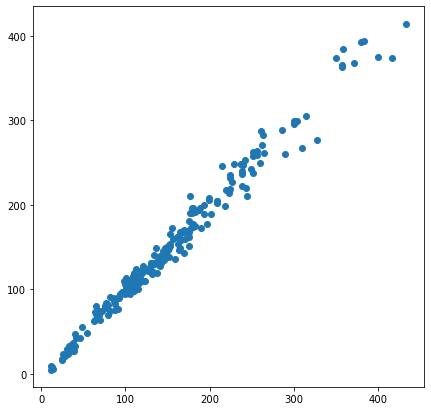

In [48]:
fig = plt.figure(figsize=(7,7))
plt.scatter(ens_preds[1][:,0].numpy(), ens_preds[1][:,1:].sum(axis=-1).numpy())

In [33]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

AssertionError: ==:
225
900

In [34]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

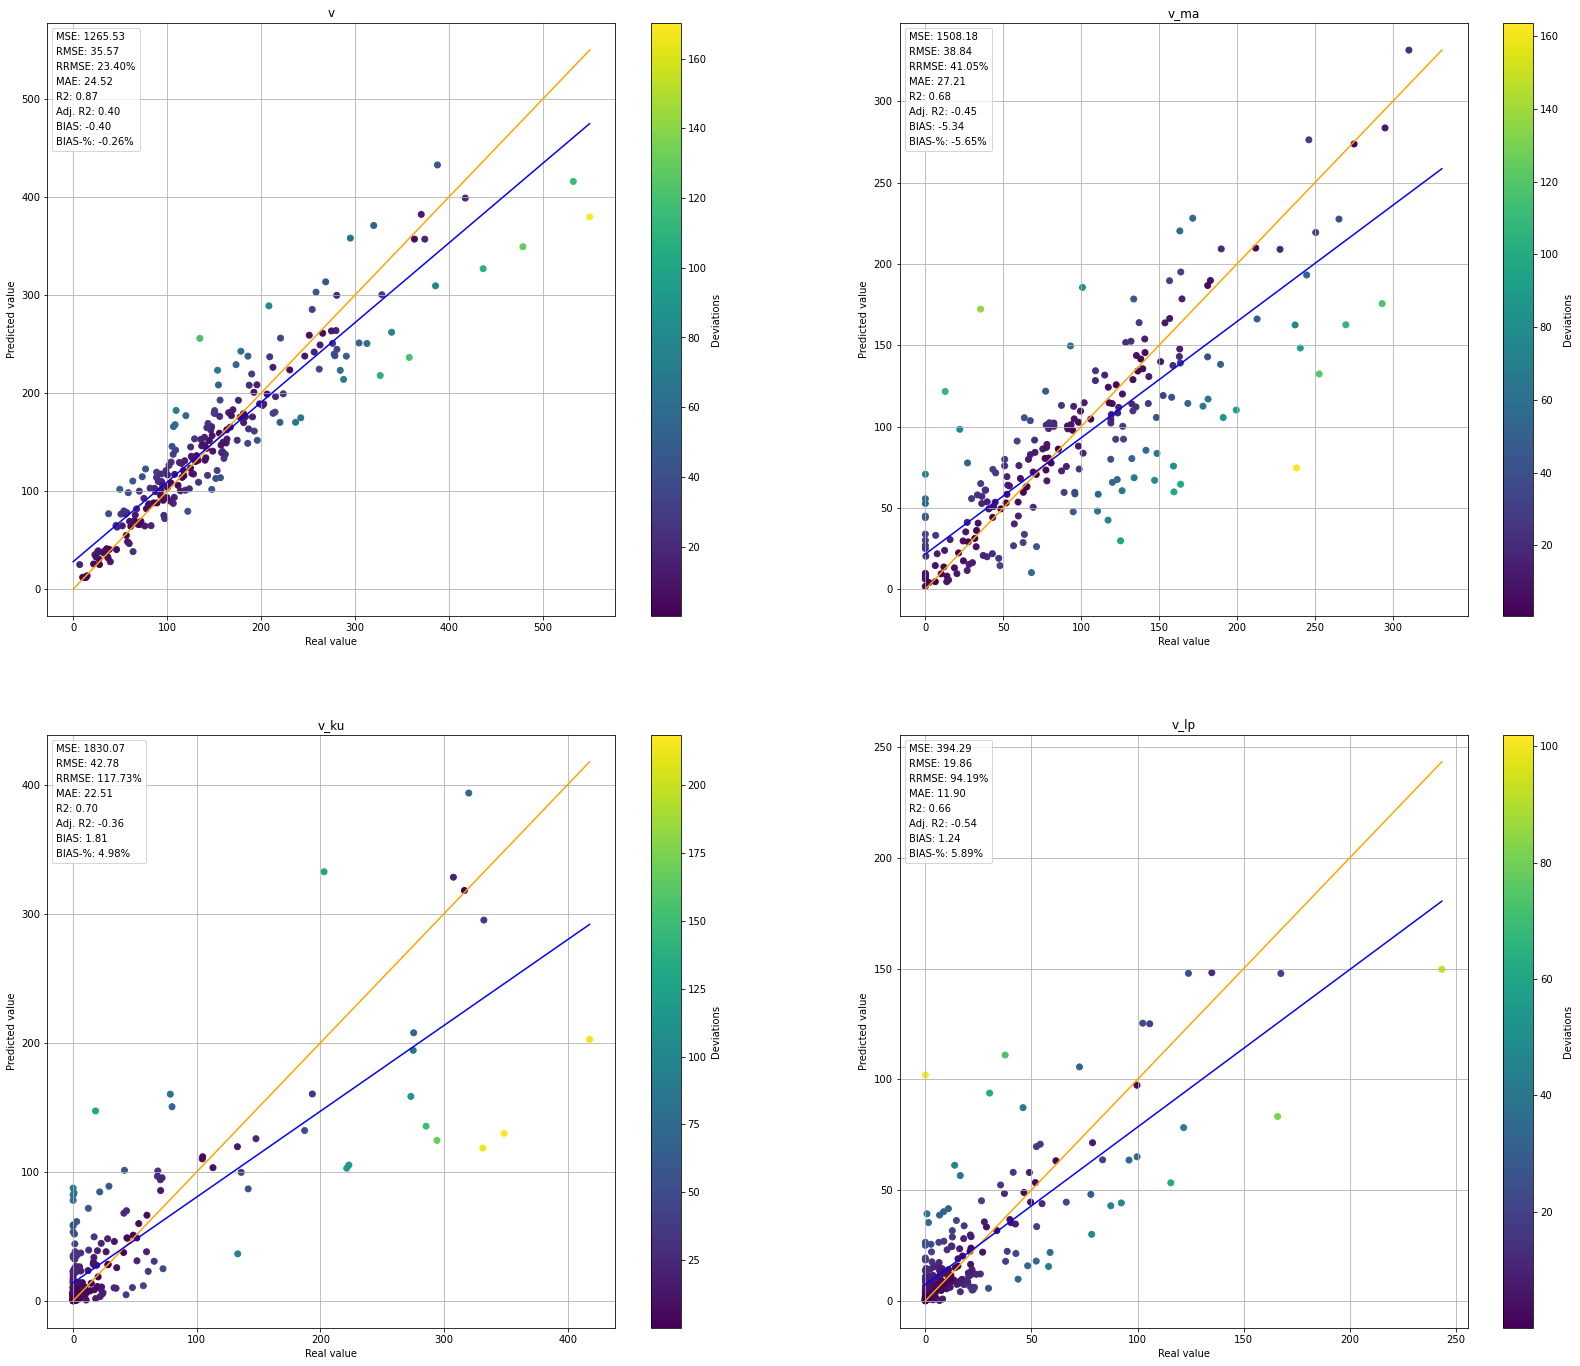

In [35]:
test_ens_interp.plot_results(log_y=False)
plt.show()

# Comparison: Random forest

`TabularPandas` makes it simple to use sklearn models with the same data and preprocessing.

In [144]:
from sklearn.ensemble import RandomForestRegressor

Below values for `max_features` and `min_samples_leaf` should generally work well.

In [145]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [146]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [147]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

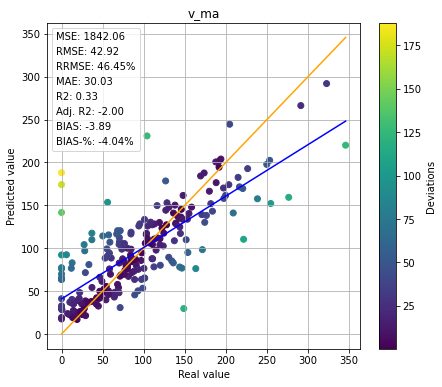

In [148]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys, log_y=False)
plt.show()

Test results

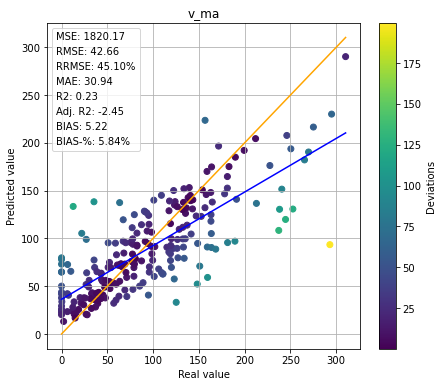

In [149]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()